In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
from os import path
from matplotlib.image import imread
import PIL.Image as pil
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
import cv2
%matplotlib inline

Using TensorFlow backend.


In [3]:
import logging
logging.captureWarnings(True)
logging.getLogger('tensorflow').setLevel(logging.CRITICAL)

In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
K.set_image_data_format('channels_last')

In [5]:
MODEL_DIR='/longterm/shared_models/glasses-attack/face-rec-attacks/'
sys.path.append(MODEL_DIR)
sys.path.append('..')

In [6]:
from FaceRecognitionNets import VGGNet

fin = open('%s/aux-data/names-10classes.txt' % MODEL_DIR, mode='r')
names = fin.read().split('\n')
fin.close()
names

['Aaron_Eckhart',
 'Brad_Pitt',
 'Clive_Owen',
 'Drew_Barrymore',
 'Milla_Jovovich',
 'ariel',
 'aya',
 'lujo',
 'mahmood',
 'sruti']

In [7]:
import glob
import re

def normalize_images(ims):
    ims_n = np.array(ims, copy=True)
    ims_n[:,:,:,0] = ims[:,:,:,0] - VGGNet.average_image[0]
    ims_n[:,:,:,1] = ims[:,:,:,1] - VGGNet.average_image[1]
    ims_n[:,:,:,2] = ims[:,:,:,2] - VGGNet.average_image[2]
    return ims_n

def unnormalize_images(ims):
    ims_n = np.array(ims, copy=True)
    ims_n[:,:,:,0] = ims[:,:,:,0] + VGGNet.average_image[0]
    ims_n[:,:,:,1] = ims[:,:,:,1] + VGGNet.average_image[1]
    ims_n[:,:,:,2] = ims[:,:,:,2] + VGGNet.average_image[2]
    return ims_n

def load_benign(model_dir, attacker, instance=0):
    imdir = '%s/images/benign/' % MODEL_DIR
    imname = 'vgg10-%d-%d.png' % (attacker, instance)
    im = imread(path.join(imdir, imname))*255.
    im = im[:,:,:3]
    im = cv2.resize(im, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    
    return im

def load_dodging(model_dir, attacker, instance=0):
    imdir = '%s/images/dodging/' % MODEL_DIR
    imname = 'vgg10-%d-%d.png' % (attacker, instance)
    im = imread(path.join(imdir, imname))*255.
    im = im[:,:,:3]
    
    return im

def load_impersonation(model_dir, attacker, target, instance=0):
    imdir = '%s/images/impersonation/' % MODEL_DIR
    imname = 'vgg10-%d-%d-%d.png' % (attacker, target, instance)
    im = imread(path.join(imdir, imname))*255.
    im = im[:,:,:3]
    
    return im

def load_all_benign(model_dir):
    imdir = os.path.join(MODEL_DIR, 'images', 'benign')
    imname = 'vgg10-*-*.png'
    files = glob.glob(os.path.join(imdir, imname))
    rec = re.compile(r'.*/vgg10-([0-9]+)-.*.png')
    labels = list(set([int(rec.match(fn).group(1)) for fn in files]))
    ims = {label: [] for label in labels}
    for file in files:
        label = int(rec.match(file).group(1))
        im = imread(file)*255.
        im = im[:,:,:3]
        im = cv2.resize(im, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        ims[label].append(im[np.newaxis])
    for label in labels:
        ims[label] = np.concatenate(ims[label], axis=0)
    return ims

def load_all_impersonation(model_dir):
    imdir = os.path.join(MODEL_DIR, 'images', 'impersonation')
    imname = 'vgg10-*-*-*.png'
    files = glob.glob(os.path.join(imdir, imname))
    rec = re.compile(r'.*/vgg10-([0-9]+)-([0-9]+)-.*.png')
    labels = list(set([int(rec.match(fn).group(1)) for fn in files]))
    ims = {label: [] for label in labels}
    targets = {label: [] for label in labels}
    for file in files:
        label = int(rec.match(file).group(1))
        target = int(rec.match(file).group(2))
        im = imread(file)*255.
        ims[label].append(im[:,:,:3][np.newaxis])
        targets[label].append(target)
    for label in labels:
        ims[label] = np.concatenate(ims[label], axis=0)
    return ims, targets

def imshow(im):
    plt.imshow(im/255.)

In [8]:
vgg_model = VGGNet('%s/weights/vgg10-recognition-nn-raw-weights.mat' % MODEL_DIR)
model = vgg_model.model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     73856     
__________

In [9]:
n_classes = model.output_shape[1]
benign_ims = load_all_benign(MODEL_DIR)
benign_ims_n = {label: normalize_images(benign_ims[label]) for label in benign_ims.keys()}
all_be_x = np.concatenate([benign_ims[label] for label in benign_ims.keys()], axis=0)
all_be_x_n = normalize_images(all_be_x)
all_be_y = np.concatenate([to_categorical(np.repeat([label], len(benign_ims[label])), 
                                          n_classes) for label in benign_ims.keys()], axis=0)
imp_ims, imp_targets = load_all_impersonation(MODEL_DIR)
imp_ims_n = {label: normalize_images(imp_ims[label]) for label in imp_ims.keys()}
all_imp_x = np.concatenate([imp_ims[label] for label in imp_ims.keys()], axis=0)
all_imp_x_n = normalize_images(all_imp_x)
all_imp_y = np.concatenate([to_categorical(np.repeat([label], len(imp_ims[label])), 
                                          n_classes) for label in imp_ims.keys()], axis=0)
all_imp_t = np.concatenate([
    np.concatenate([
        to_categorical(t, n_classes)[np.newaxis] 
        for t in imp_targets[label]], axis=0) 
    for label in imp_ims.keys()], axis=0)

In [195]:
imp_targets[7][0], imp_targets[8][0], imp_targets[9][0]

(4, 5, 1)

In [190]:
benign_ims_n.keys()

dict_keys([0, 1, 3, 5, 7, 8, 9])

In [202]:
0 in benign_ims_n.keys()

True

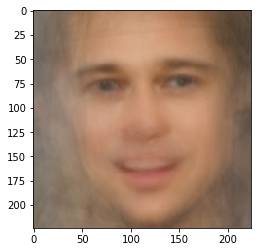

In [200]:
imshow(benign_ims[1].mean(axis=0))

# Explaining Misclassifications

In [10]:
sys.path.append('..')
from attribution.methods import AumannShapley
from attribution.visualizations import TopKWithBlur, UnitsWithBlur

In [11]:
from keras import Model
logit_model = Model(model.input, model.layers[-2].output)

In [12]:
def get_smooth_mask(im_t_n, asa, vistop, nsmooth=100):
    im_t_n_s = np.random.normal(loc=0,
                                scale=np.sqrt(im_t_n.var()),
                                size=(nsmooth,) + im_t_n.shape)[:] + im_t_n
    attrs = asa.get_attributions(im_t_n_s).mean(axis=0)
    mask = vistop.mask_np(im_t_n, attrs)
    return mask

In [13]:
def show_vis(o, m, r):
    h, w, c = o.shape
    v = np.zeros(shape=(h,w*3,c), dtype=o.dtype)
    v[:,:w,:] = o[:,:,:]
    v[:,w:2*w,:] = m[:,:,:]
    v[:,2*w:3*w,:] = r[:,:,:]
    plt.gcf().set_size_inches(15,8)
    imshow(unnormalize_images(v[np.newaxis])[0])

### Layer = 16

In [14]:
layer = 16

In [186]:
nunit = 5
percentile = 90
t = 8

In [187]:
asa = AumannShapley(logit_model,
                    layer,
                    agg_fn=K.max,
                    Q=logit_model.output[:, imp_targets[t][0]],
                    multiply_activation=True).compile()
vistop = TopKWithBlur(asa, k=nunit, sigma=0, percentile=percentile, alpha=0.)
mean_vic = all_be_x_n.mean(axis=0)  # benign_ims_n[imp_targets[l][0]].mean(axis=0)

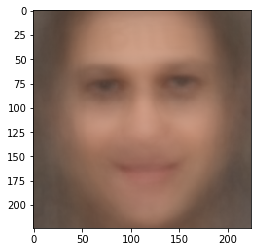

In [188]:
imshow(unnormalize_images(mean_vic[np.newaxis])[0])

[5] [0.93665457] [8] [0.98610663] [8] [0.9930347]


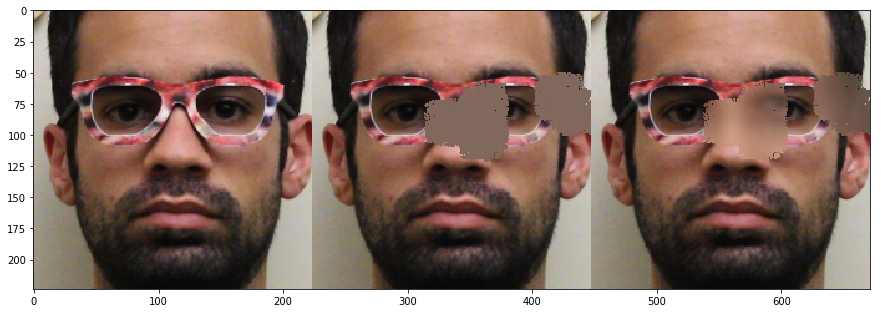

In [189]:
im_t_n = imp_ims_n[t][19]
mask = get_smooth_mask(im_t_n, asa, vistop, 100)
im_r_n = im_t_n * (1. - mask) + mean_vic * mask
p_mask = model.predict(im_t_n[np.newaxis] * (1. - mask))
p_repl = model.predict(im_r_n[np.newaxis])
print(model.predict(im_t_n[np.newaxis]).argmax(axis=1),
      model.predict(im_t_n[np.newaxis]).max(axis=1),
      p_mask.argmax(axis=1), 
      p_mask.max(axis=1),
      p_repl.argmax(axis=1), 
      p_repl.max(axis=1))
show_vis(im_t_n, im_t_n*(1.-mask), im_r_n)

In [414]:
model.predict(im_t_n[np.newaxis]*(1.-mask_23_0)).argmax(), model.predict(im_t_n[np.newaxis]).argmax()

(8, 5)

In [415]:
im_n, im = np.array(benign_ims_n[8][idx], copy=True), np.array(benign_ims[8][idx], copy=True)
im_n[np.where(mask_23_0 > 0.5)] = im_t_n[np.where(mask_23_0 > 0.5)]
im[np.where(mask_23_0 > 0.5)] = im_t[np.where(mask_23_0 > 0.5)]
z_im = np.zeros_like(im_n)
z_im[np.where(mask_23_0 > 0.5)] = im_t_n[np.where(mask_23_0 > 0.5)]
model.predict(im_n[np.newaxis]).argmax(), model.predict(z_im[np.newaxis]).argmax()

(8, 8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


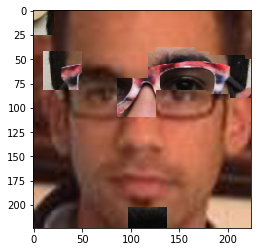

In [416]:
imshow(im)